# Introduction to qgs tutorial

This notebook is a tutorial in which you will learn:

1. How to install the [qgs](https://github.com/Climdyn/qgs) framework for low-order climate and weather modeling
2. How to run the model
3. Some details about how the model works inside


This is a simple introduction to the model, only to show how to use the model and to allow you to play a bit with the model parameters.

As you run this notebook, remember that a full documentation is available online to help you as well on

> [qgs.readthedocs.io](https://qgs.readthedocs.io/en/latest/)

## Model & tutorial installation

If it not yet done, you will instructions here on how to install qgs.

### With pip

The easiest way to install and run qgs is to use [pip](https://pypi.org/). Simply uncomment and run the line below:

In [ ]:
#!pip install qgs

and you are set!

### With Anaconda

To install qgs and this tutorial, you will need first to install [Anaconda](https://www.anaconda.com/) on your laptop. Then clone the qgs repository and follow the [installation instructions](https://github.com/Climdyn/qgs#installation). You can then copy this tutorial notebook in the **root folder** of qgs and you are ready.

## Running the model

Using qgs, we will now define a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley). Subsequently, we will integrate this model and plot its trajectories.

More details on this model version can be found in the articles:
* Reinhold, B. B., & Pierrehumbert, R. T. (1982). *Dynamics of weather regimes: Quasi-stationary waves and blocking*. Monthly Weather Review, **110** (9), 1105-1145. [doi:10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2](https://doi.org/10.1175/1520-0493(1982)110%3C1105:DOWRQS%3E2.0.CO;2)

or in the [documentation](https://qgs.readthedocs.io/en/latest/files/model/oro_model.html).

**To start, simply run the current notebook and follow the cells down to the bottom.**

### Modules import

First, load some modules

In [ ]:
import sys, os
sys.path.extend([os.path.abspath('../')])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Importing the model's modules

In [ ]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [ ]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

### Defining the model

First, we define some general parameters

In [ ]:
# Time increment parameter
dt = 0.1
# Saving the model state every 5 steps
write_steps = 5
# transient time
transient_time = 200000.
# integration time
integration_time = 100000.

Now we will create the model parameters object. It is an object which entirely define the model version and parameters. This object will be use by qgs to construct the tendencies $\boldsymbol{f}$ of the model.

In [ ]:
model_parameters = QgParams()

We can now setup some parameters with the [`set_params`](https://qgs.readthedocs.io/en/latest/files/technical/configuration.html#qgs.params.params.Params.set_params) method of the parameters object:

In [ ]:
# here we define the latitude to be 50 degrees and a predefined amplitude of the meridional temperature gradient
model_parameters.set_params({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.045})

and indicate that we want an atmospheric channel for the atmosphere, with Fourier modes up to wavenumber 2 in each spatial direction (directions $x$ and $y$, which will be clarified below):

In [ ]:
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

We also set some topography

In [ ]:
model_parameters.ground_params.set_orography(0.2, 1)

and indicate the amplitude of the meridional temperature gradient which forces the model:

In [ ]:
model_parameters.atemperature_params.set_thetas(0.1, 0)

and we are done configuring the model. We can now print the parameters to check what we have done:

In [ ]:
model_parameters.print_params()

We are now ready to feed the parameters object to qgs to get the tendencies $\boldsymbol{f}$ that will allow us to integrate the differential equation $\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x})$

In [ ]:
%%time
f, Df = create_tendencies(model_parameters)

### Time integration

We can now integrate our model with an integrator, an algorithm that will give us the solution of the differential equation above. There are many options for doing that, but here we will use qgs built-in integrator (a [Runge-Kutta 4th-order integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)):

In [ ]:
integrator = RungeKuttaIntegrator()

We will tell this integrator to use our freshly defined model

In [ ]:
integrator.set_func(f)

We can now start from a small random initial condition and integrate over a transient time to obtain an initial condition on the model attractor:

In [ ]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., transient_time, dt, ic=ic, write_steps=0)  # write_steps=0 will only give us the last step
time, ic = integrator.get_trajectories()

Now that we have obtained an initial condition on the attractor, we can integrate further to obtain a **trajectory** on the attractor

In [ ]:
%%time
integrator.integrate(0., integration_time, dt, ic=ic, write_steps=write_steps)
time, trajectory = integrator.get_trajectories()

### Plotting the trajectory of the model

The typical time evolution of a model variable as a function of time can now be plotted:

In [ ]:
var = 1
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, trajectory[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

We can also plot for example the 2nd and 3rd variables in a plane.

In [ ]:
varx = 2
vary = 1
plt.figure(figsize=(10, 8))

plt.plot(trajectory[varx], trajectory[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

This show a 2-dimensional projection of the [attractor](https://en.wikipedia.org/wiki/Attractor) of the model, i.e. the set of states toward which the model tends to evolve, for a wide variety of starting conditions of the system.

Each point is a state of the model. $\psi_{\rm{a},2}$ and $\psi_{\rm{a},3}$ correspond to the 2nd and 3rd variables of the model. These are *spectral* coefficients of the model. Indeed, qgs is a spectral model. It means that all its fields are expanded on spatial modes. Here for instance, there are two fields, the 500hPa streamfunction $\psi_{\rm{a}}$ and the 500hPa temperature $\theta_{\rm{a}}$. They are expanded on the 10 modes (because we decided to expand up to wavenumber 2 in each direction):

$$\psi_{\rm{a}} = \sum_{i=1}^{10} \, \psi_{\rm{a},i} \, F_i(x,y)\qquad\qquad \mathrm{(1)}$$ 
$$\theta_{\rm{a}} = \sum_{i=1}^{10} \, \theta_{\rm{a},i} \, F_i(x,y) \qquad\qquad\,\, \mathrm{(2)}$$

where

$$ F_1(x,y) = \sqrt{2}\, \cos(y), \\ F_2(x,y) =  2\, \cos(n x)\, \sin(y), \\ F_3(x,y) =  2\, \sin(n x)\, \sin(y), \\ F_4(x,y) =  \sqrt{2}\, \cos(2y), \\ F_5(x,y) = 2  \cos(n x) \sin(2y), \\ F_6(x,y) = 2 \sin(n x) \sin(2y), \\ \vdots $$

and where $x$ and $y$ are the nondimensional coordinates on the model spatial domain (a $\beta$-plane): $x \in [0, 2\pi/n]$ and $y \in [0,\pi]$, with $n$ the aspect ratio of the domain, i.e. the ratio between the zonal and meridional extent of the domain.

Here are the 10 modes (shown for $n=1$) over which the spatial fields $\psi_{\rm{a}}$ and $\theta_{\rm{a}}$ of the model are decomposed:
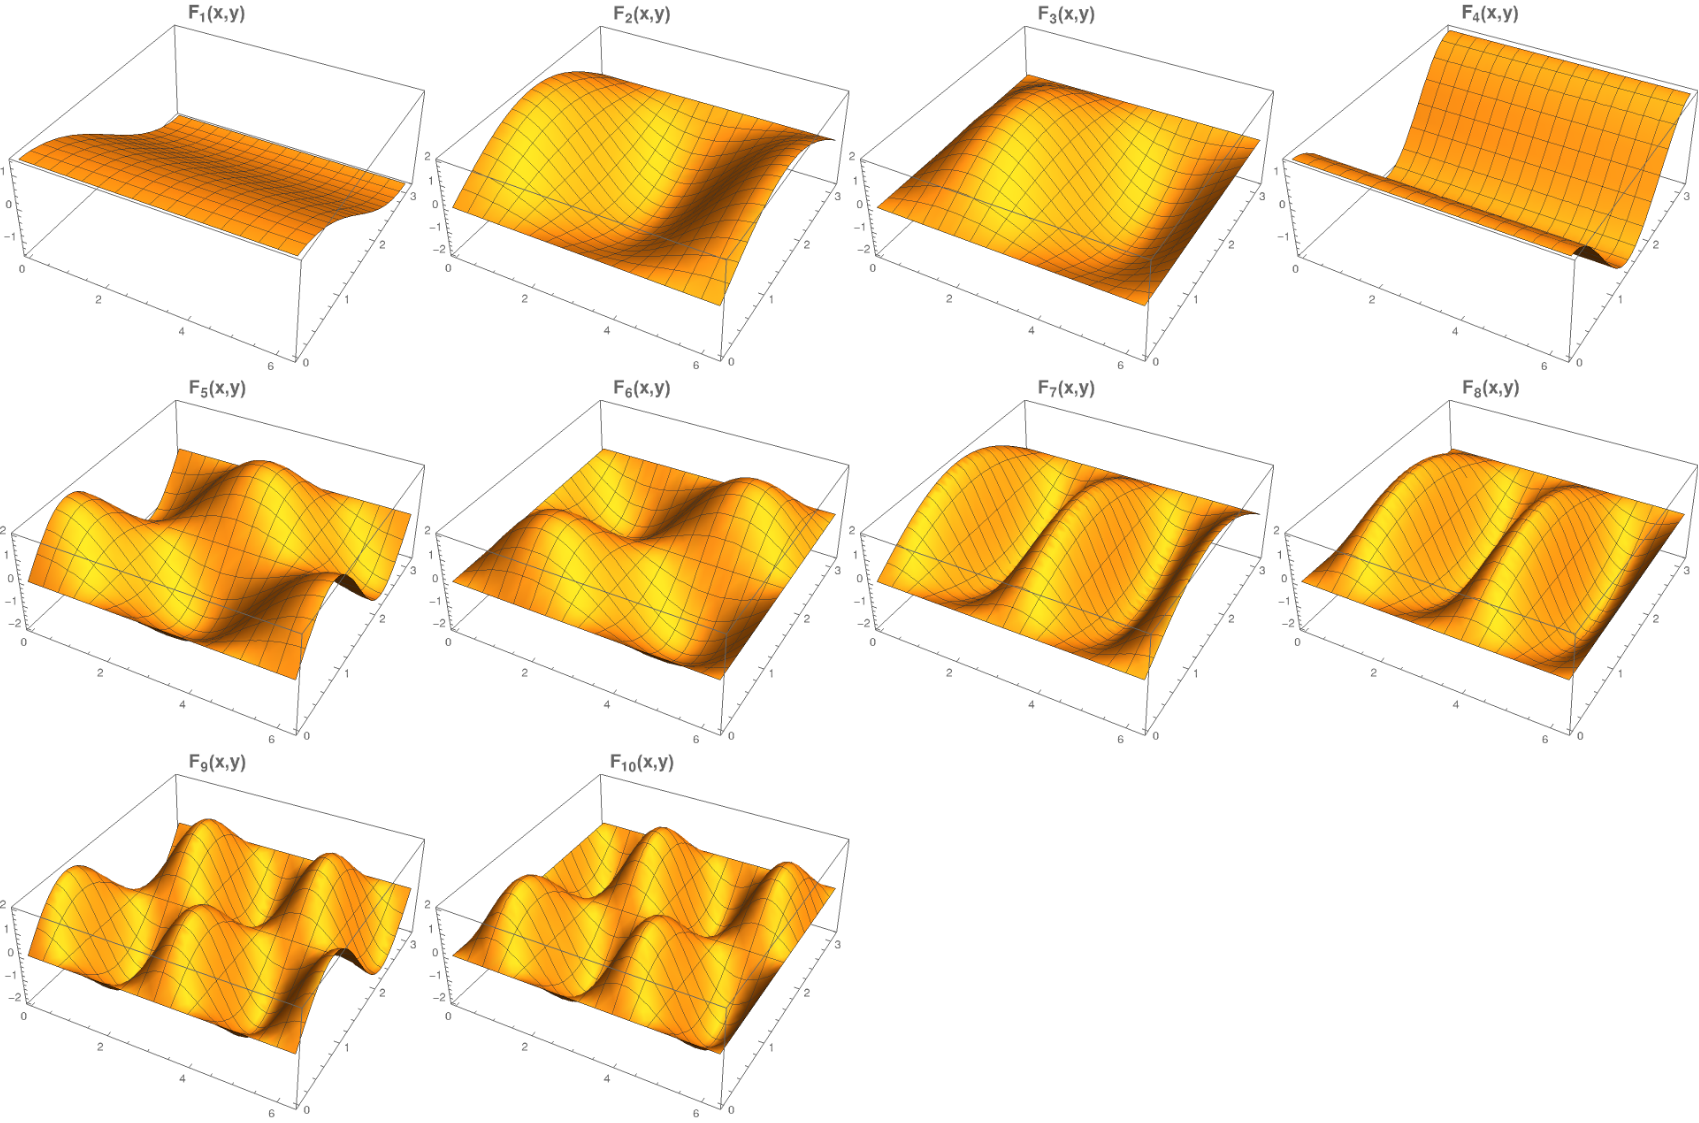

Now, when we integrate $\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x})$, we integrate a differential equation for the time evolution of the spectral coefficients $\psi_{\rm{a}, i}$ and $\theta_{\rm{a}, i}$. That is, in our case, $\boldsymbol{x} = (\psi_{\rm{a}, 1}, \ldots, \psi_{\rm{a}, 10}, \theta_{\rm{a}, 1}, \ldots, \theta_{\rm{a}, 10})$, and solving the model differential equation allow us to determine $\boldsymbol{x}(t)$. With the equations (1) and (2), it is then easy to reconstruct the time evolution of the spatial fields of the model. That is exactly what the [`Diagnostic`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html) objects in the model do, and the subject of the next section.

> **Info:** See this [page](https://qgs.readthedocs.io/en/latest/files/model/oro_model.html) for more details about the spectral expansion. 

### Computing and plotting spatial fields of the model

Computation and plotting of the model fields can be done with objects called diagnostics, which take the output of the model integration (i.e. the spectral coefficients) and convert it to spatial fields. A list of currently available diagnostics is included in this section of the [User guide on diagnostics usage](https://qgs.readthedocs.io/en/latest/files/user_guide.html#analyzing-the-model-s-output-with-diagnostics).

For this tutorial, we are going to compute the 500hPa geopotential height spatial field. This can be done with the [`MiddleAtmosphericStreamfunctionDiagnostic`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html#qgs.diagnostics.streamfunctions.MiddleAtmosphericStreamfunctionDiagnostic) which compute $\psi_{\rm a}(x, y)$.

To compute it, we start by instantiating the object:

In [ ]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

where the `geopotential=True` statement is just to specify that we want the streamfunction to be expressed as a [geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) anomaly. Note also that we need to pass the `model_parameters` object that we defined above.

Now we need to pass the model integration data to with the [`set_data`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html#qgs.diagnostics.base.Diagnostic.set_data) method:

In [ ]:
psi.set_data(time, trajectory)

The diagnostic can now compute the fields on the fly by calling

In [ ]:
psi.diagnostic

All the spatial fields corresponding to the time evolution of the model variables are returned as an array on specific points $x$ and $y$:

In [ ]:
psi.diagnostic.shape

Here there are 200001 recorded time step of a field represented by a 10 by 10 grid. We can plot a single field at the 100-th recorded time steps with:

In [ ]:
plt.imshow(psi.diagnostic[100])

or use the built-in diagnostic plot function:

In [ ]:
psi.plot(100)

As a final remark, please note that the $x$ or $y$ coordinates of the grid points are available in the diagnostics object as:

In [ ]:
psi._X

and

In [ ]:
psi._Y

### Showing the resulting fields as an animation

With diagnostics, one can also show the time evolution of fields of the model. Here, we show simultaneously a scatter plot of the variable $\psi_{{\rm a}, 2}$ and $\psi_{{\rm a}, 3}$, and the geopotential height field at 500 hPa over the orographic height. For more details on the diagnostics and how to use them to produce this kind of animation, please read this section of the [User guide](https://qgs.readthedocs.io/en/latest/files/user_guide.html#analyzing-the-model-s-output-with-diagnostics).

In [ ]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
variable_nondim = VariablesDiagnostic([2, 1], model_parameters, False)
background = VariablesDiagnostic([2, 1], model_parameters, False)
background.set_data(time, trajectory)

m = MultiDiagnostic(1,2)
m.add_diagnostic(variable_nondim,
                 diagnostic_kwargs={'show_time': False, 'background': background},
                 plot_kwargs={'ms': 0.2})
m.add_diagnostic(psi,
                 diagnostic_kwargs={'style': 'contour', 'contour_labels': False},
                 plot_kwargs={'colors': 'k'})
m.set_data(time, trajectory)

m.animate(figsize=(20,6))

## Exercise

A simple exercise for this introduction is to restart this notebook a few times, changing some models parameters to see the effect.
A full description of all the available parameters is provided [here](https://qgs.readthedocs.io/en/latest/files/technical/configuration.html).